# Exploring Dandiset 001361: A Flexible Hippocampal Population Code for Experience Relative to Reward

**Note:** This notebook was generated with the assistance of AI. Please exercise caution when interpreting the code or results.

## Overview

This dataset contains two-photon calcium imaging and behavioral data from hippocampal area CA1 in mice as they navigate virtual environments with changing hidden reward locations. The data support the study by Sosa, Plitt, & Giocomo, "A flexible hippocampal population code for experience relative to reward" (Nature Neuroscience, 2025).

**Research question addressed:** How do hippocampal place cells encode and adapt their firing fields in relation to sequences of events around reward locations during navigation and learning?

**Dataset:** [DANDI:001361](https://dandiarchive.org/dandiset/001361/0.250406.0045)

**Key features:**
- Species: Mus musculus (House mouse)
- 11 mice, 152 NWB files (~92.6 GB total)
- Two-photon calcium imaging from CA1
- Behavioral tracking in virtual reality environments
- Suite2p-processed cell segmentation and fluorescence traces

## Required Packages

```python
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
from itertools import islice
```

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
from itertools import islice

## Exploring the Dandiset with DANDI API

In [2]:
# Connect to the DANDI Archive and get basic information about the dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001361", "0.250406.0045")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description'][:200]}...")

Dandiset name: A flexible hippocampal population code for experience relative to reward
Dandiset URL: https://dandiarchive.org/dandiset/001361/0.250406.0045
Description: 2-photon imaging and behavioral data from hippocampal area CA1 during virtual reality navigation in mice. Included in Sosa, Plitt, & Giocomo, "A flexible hippocampal population code for experience rel...


## Enumerating NWB Files in the Dandiset

In [3]:
# Get all .nwb files in the dandiset
assets = list(dandiset.get_assets_by_glob('*.nwb'))

# Create summary of files
files_info = [
    {'path': a.path, 'size_MB': round(a.size / 1e6, 2)}
    for a in assets
]

files_table = pd.DataFrame(files_info)

print(f"Total number of NWB files: {len(files_table)}")
print(f"Combined size: ~{files_table['size_MB'].sum() / 1000:.1f} GB")
print("\nFirst 10 files:")
print(files_table.head(10))

Total number of NWB files: 152
Combined size: ~92.6 GB

First 10 files:
                                        path  size_MB
0  sub-m11/sub-m11_ses-05_behavior+ophys.nwb    99.31
1  sub-m11/sub-m11_ses-04_behavior+ophys.nwb    89.67
2  sub-m11/sub-m11_ses-07_behavior+ophys.nwb   119.72
3  sub-m11/sub-m11_ses-06_behavior+ophys.nwb    94.61
4  sub-m11/sub-m11_ses-08_behavior+ophys.nwb   128.45
5  sub-m11/sub-m11_ses-10_behavior+ophys.nwb   110.88
6  sub-m11/sub-m11_ses-03_behavior+ophys.nwb    93.43
7  sub-m11/sub-m11_ses-09_behavior+ophys.nwb   110.02
8  sub-m11/sub-m11_ses-11_behavior+ophys.nwb   111.62
9  sub-m11/sub-m11_ses-12_behavior+ophys.nwb   120.94


Each NWB file represents one experimental session for a subject and contains both behavioral and two-photon imaging data. Files are organized by subject (`sub-XX`) and session (`ses-XX`), with the suffix `behavior+ophys` indicating combined modalities.

## Loading and Exploring an Example NWB File

Let's examine the structure and contents of one session to understand what data is available.

In [4]:
# Load an example NWB file using remote streaming
asset_path = "sub-m11/sub-m11_ses-05_behavior+ophys.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url

# Open remote NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract key metadata
subject_info = {
    'subject_id': nwb.subject.subject_id,
    'species': nwb.subject.species,
    'sex': nwb.subject.sex,
    'date_of_birth': str(nwb.subject.date_of_birth.date())
}

session_info = {
    'session_id': nwb.session_id,
    'session_start_time': str(nwb.session_start_time.date()),
    'description': nwb.session_description,
    'experimenter': nwb.experimenter
}

print("Subject Information:")
for key, value in subject_info.items():
    print(f"  {key}: {value}")

print("\nSession Information:")
for key, value in session_info.items():
    print(f"  {key}: {value}")

Subject Information:
  subject_id: m11
  species: Mus musculus
  sex: M
  date_of_birth: 2022-09-20

Session Information:
  session_id: 05
  session_start_time: 2023-02-25
  description: processed suite2p data
  experimenter: ('Mari Sosa',)


## Understanding the NWB File Structure

In [5]:
# Examine the main data modalities in this NWB file

# Get imaging information
ophys_proc = nwb.processing['ophys']
flu = ophys_proc.data_interfaces['Fluorescence'].roi_response_series['plane0']
trace_shape = flu.data.shape

# Get segmentation information
seg = ophys_proc.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
n_cells = seg.id.data.shape[0]

# List available behavioral signals
behavior_mod = nwb.processing['behavior'].data_interfaces['BehavioralTimeSeries']
timeseries_list = list(behavior_mod.time_series.keys())

print(f"Calcium trace array shape [frames, cells]: {trace_shape}")
print(f"Number of segmented cells/ROIs: {n_cells}")
print(f"Imaging rate: {flu.rate} Hz")

print(f"\nAvailable behavioral signals:")
for signal in timeseries_list:
    print(f"  - {signal}")

Calcium trace array shape [frames, cells]: (20684, 358)
Number of segmented cells/ROIs: 358
Imaging rate: 15.5078125 Hz

Available behavioral signals:
  - Reward
  - autoreward
  - environment
  - lick
  - position
  - reward_zone
  - scanning
  - speed
  - teleport
  - trial number
  - trial_start


The NWB file contains:
- **Calcium imaging data**: Fluorescence traces for 358 segmented cells over 20,684 time points
- **Behavioral data**: Multiple time series aligned to imaging frames, including position, speed, licks, rewards, and trial information
- **Cell segmentation**: Suite2p-processed ROI masks and classification

## Visualizing Behavioral Data

Let's examine key behavioral signals over the first few minutes of the session to understand the experimental paradigm.

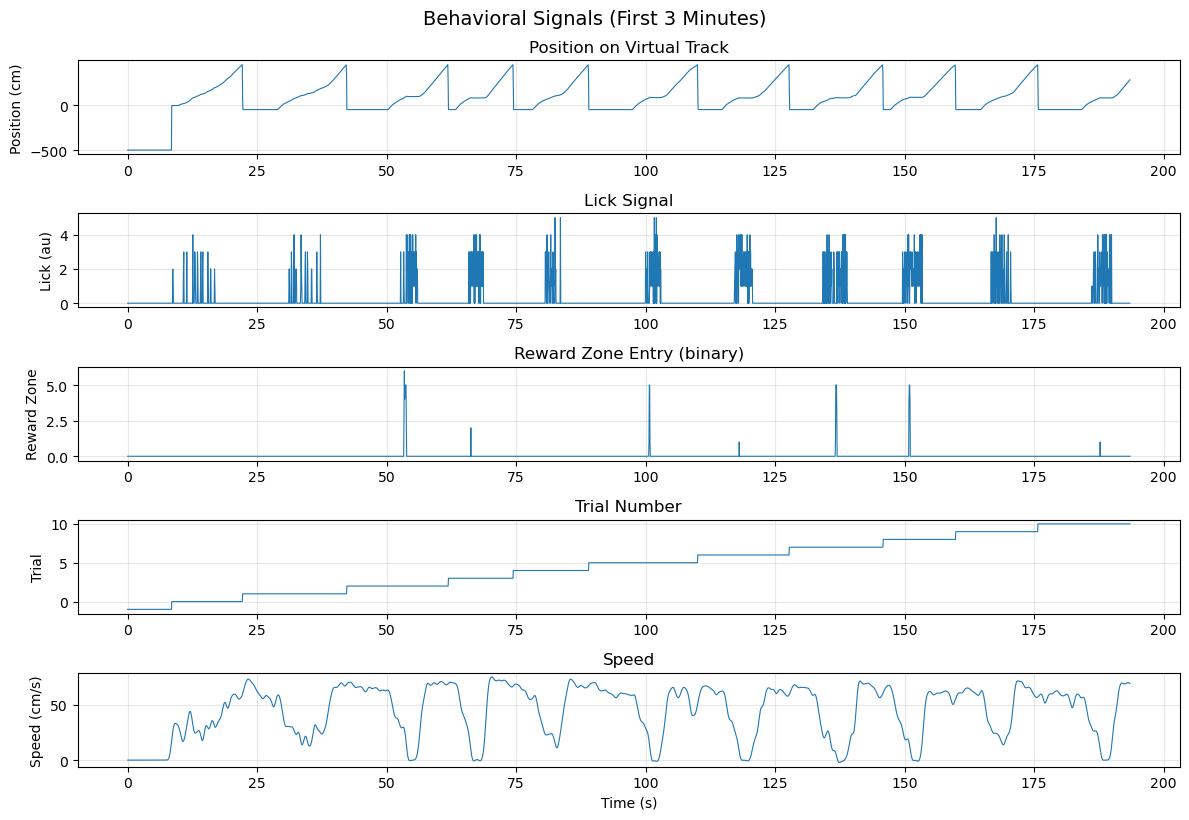

Summary statistics for behavioral signals:
position: min=-500.00, max=449.75, mean=71.41
lick: min=0.00, max=5.00, mean=0.28
reward_zone: min=0.00, max=6.00, mean=0.03
trial number: min=-1.00, max=10.00, mean=4.74
speed: min=-2.08, max=74.89, mean=44.50


In [6]:
# Extract behavioral signals for visualization (first ~3 minutes)
N = 3000  # ~3 minutes at 15.5 Hz
beh_signals = {}
for key in ['position', 'lick', 'reward_zone', 'trial number', 'speed']:
    ts = behavior_mod.time_series[key]
    beh_signals[key] = ts.data[:N]

# Time vector for plotting
time_sec = np.arange(N) / 15.5

# Create multi-panel plot of behavioral signals
plt.figure(figsize=(12, 8))

plt.subplot(511)
plt.plot(time_sec, beh_signals['position'], linewidth=0.8)
plt.ylabel('Position (cm)')
plt.title('Position on Virtual Track')
plt.grid(True, alpha=0.3)

plt.subplot(512)
plt.plot(time_sec, beh_signals['lick'], linewidth=0.8)
plt.ylabel('Lick (au)')
plt.title('Lick Signal')
plt.grid(True, alpha=0.3)

plt.subplot(513)
plt.plot(time_sec, beh_signals['reward_zone'], linewidth=0.8)
plt.ylabel('Reward Zone')
plt.title('Reward Zone Entry (binary)')
plt.grid(True, alpha=0.3)

plt.subplot(514)
plt.plot(time_sec, beh_signals['trial number'], linewidth=0.8)
plt.ylabel('Trial')
plt.title('Trial Number')
plt.grid(True, alpha=0.3)

plt.subplot(515)
plt.plot(time_sec, beh_signals['speed'], linewidth=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Speed')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Behavioral Signals (First 3 Minutes)', y=1.02, fontsize=14)
plt.show()

# Print summary statistics
print("Summary statistics for behavioral signals:")
for signal, data in beh_signals.items():
    print(f"{signal}: min={np.min(data):.2f}, max={np.max(data):.2f}, mean={np.mean(data):.2f}")

The behavioral data reveals the experimental structure:
- **Position**: Shows repeated laps on a virtual track with resets (indicating trial structure)
- **Trial progression**: Stepwise increases showing discrete trials/laps
- **Speed and licks**: Variable across trials, with speed dropping to near zero during inter-trial intervals
- **Reward zone**: Sparse events indicating specific reward delivery times

The data structure allows for trial-by-trial analysis of neural activity relative to spatial position and behavioral events.

## Exploring Imaging Data: Summary Images and Cell Segmentation

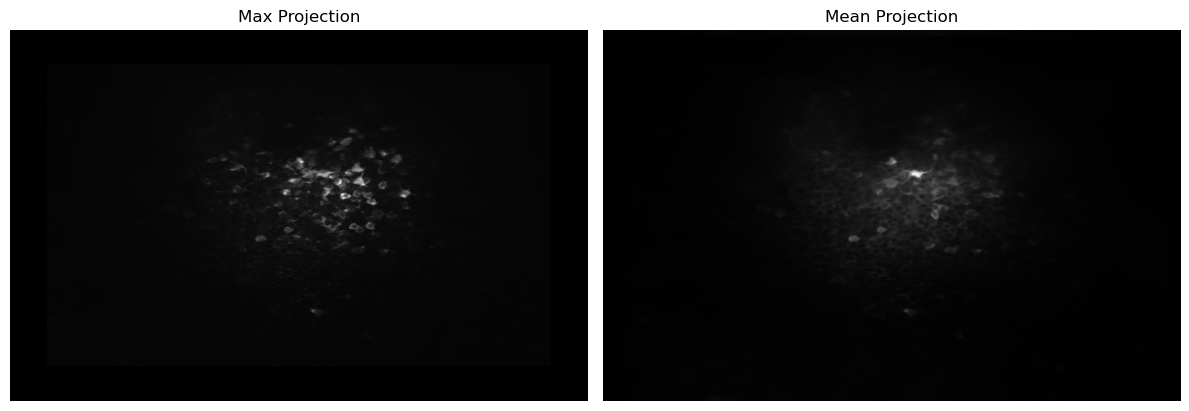

Total ROIs detected: 358
ROIs classified as cells (iscell=1): 189
Mean cell probability: 0.532


In [7]:
# Load summary images from Suite2p processing
backgrounds = ophys_proc.data_interfaces['Backgrounds_0'].images
max_proj = backgrounds['max_proj'].data[:]
mean_img = backgrounds['meanImg'].data[:]

# Plot summary images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(max_proj, cmap='gray')
axes[0].set_title('Max Projection')
axes[0].axis('off')

axes[1].imshow(mean_img, cmap='gray')
axes[1].set_title('Mean Projection')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Examine cell segmentation results
iscell = seg['iscell'].data
n_putative_cells = np.sum(iscell[:, 0] == 1)
probcell_mean = np.mean(iscell[:, 1])

print(f"Total ROIs detected: {n_cells}")
print(f"ROIs classified as cells (iscell=1): {n_putative_cells}")
print(f"Mean cell probability: {probcell_mean:.3f}")

The summary images show the field of view from CA1 hippocampus:
- **Max projection**: Reveals cell bodies and high-activity regions
- **Mean projection**: Shows overall signal and background structure

Suite2p identified 358 ROIs, of which a subset are classified as putative cells based on morphological and activity criteria.

## Analyzing Calcium Fluorescence Traces

Now let's examine the calcium imaging data by plotting fluorescence traces for example cells.

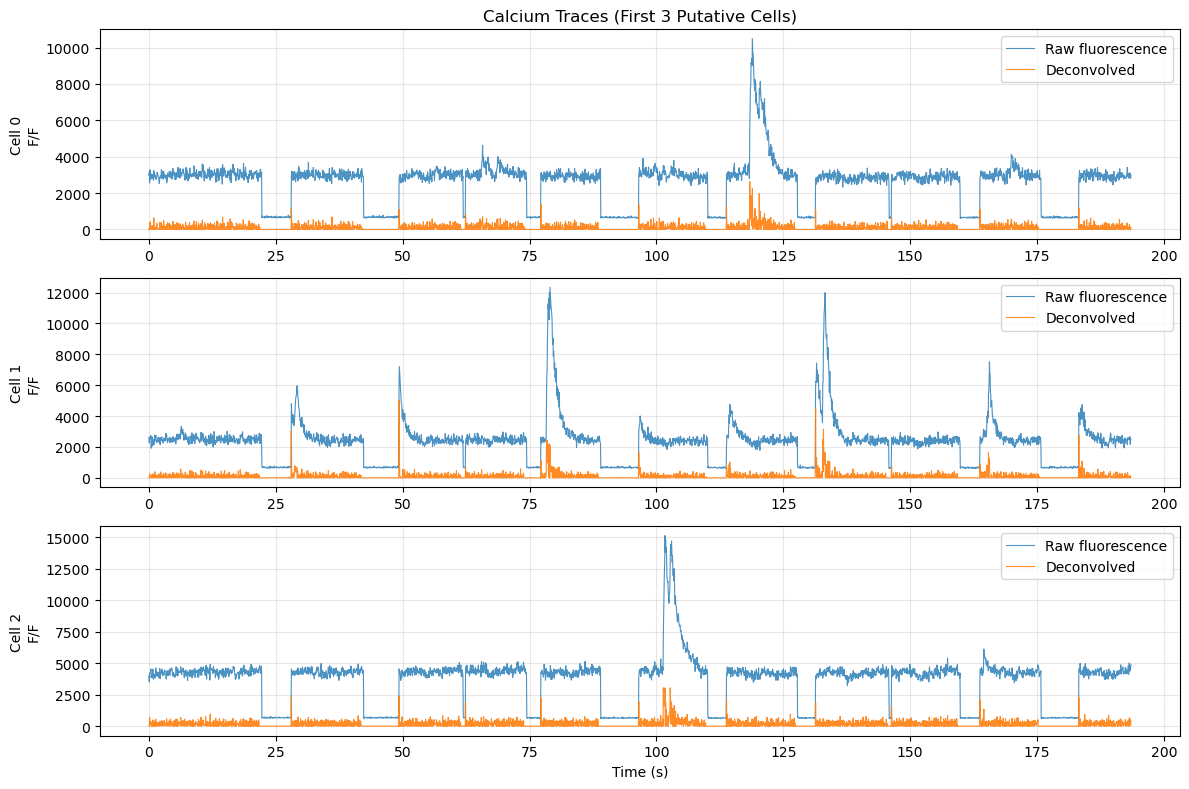

Fluorescence trace statistics (first 3 cells):
Cell 0: mean=2571, std=1193
Cell 1: mean=2325, std=1362
Cell 2: mean=3641, std=1866


In [8]:
# Select the first 3 putative cells for demonstration
cell_indices = np.where(iscell[:, 0] == 1)[0][:3]

# Extract fluorescence and deconvolved traces
flu_traces = ophys_proc.data_interfaces['Fluorescence'].roi_response_series['plane0'].data[:, cell_indices]
dec_traces = ophys_proc.data_interfaces['Deconvolved'].roi_response_series['plane0'].data[:, cell_indices]

# Plot traces for the first 3 minutes
Ntrace = 3000
time_sec = np.arange(Ntrace) / 15.5

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time_sec, flu_traces[:Ntrace, i], label='Raw fluorescence', alpha=0.8, linewidth=0.8)
    plt.plot(time_sec, dec_traces[:Ntrace, i], label='Deconvolved', alpha=0.9, linewidth=0.8)
    plt.ylabel(f'Cell {cell_indices[i]}\nF/F')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.title('Calcium Traces (First 3 Putative Cells)')
    if i == 2:
        plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Calculate and display trace statistics
flu_means = np.mean(flu_traces[:Ntrace, :], axis=0)
flu_stds = np.std(flu_traces[:Ntrace, :], axis=0)

print("Fluorescence trace statistics (first 3 cells):")
for i in range(3):
    print(f"Cell {cell_indices[i]}: mean={flu_means[i]:.0f}, std={flu_stds[i]:.0f}")

The calcium traces show:
- **Raw fluorescence**: Change in fluorescence (ΔF/F) over time
- **Deconvolved traces**: Suite2p-processed signals emphasizing transient events (likely corresponding to action potentials)

Notice how the traces show structured patterns that align with the behavioral trial structure, with periods of activity and relative quiescence corresponding to active navigation and inter-trial intervals.

## Population-Level Analysis

Let's examine population dynamics by averaging across multiple cells.

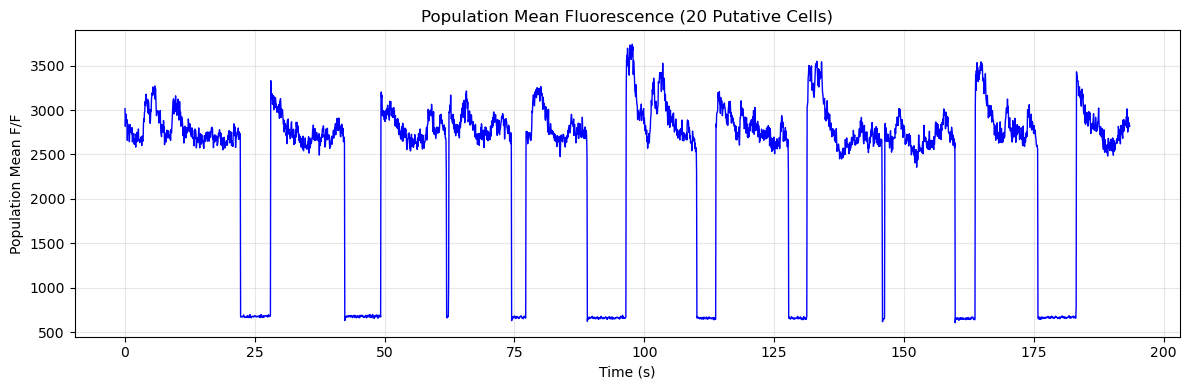

Population activity statistics:
Mean: 2349
Standard deviation: 912
Dynamic range: 606 to 3739


In [9]:
# Calculate population mean fluorescence
n_pop_cells = 20  # Use first 20 putative cells for population average
pop_cell_indices = np.where(iscell[:, 0] == 1)[0][:n_pop_cells]
pop_flu_traces = flu_traces = ophys_proc.data_interfaces['Fluorescence'].roi_response_series['plane0'].data[:, pop_cell_indices]
pop_mean = np.mean(pop_flu_traces[:Ntrace, :], axis=1)

plt.figure(figsize=(12, 4))
plt.plot(time_sec, pop_mean, linewidth=1, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Population Mean F/F')
plt.title(f'Population Mean Fluorescence ({n_pop_cells} Putative Cells)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Population activity statistics:")
print(f"Mean: {np.mean(pop_mean):.0f}")
print(f"Standard deviation: {np.std(pop_mean):.0f}")
print(f"Dynamic range: {np.min(pop_mean):.0f} to {np.max(pop_mean):.0f}")

The population mean shows coordinated activity patterns that likely reflect shared responses to behavioral events and task structure. The periodicity in the signal corresponds to the trial-based nature of the virtual navigation task.

## Data Access Summary

This notebook demonstrates how to:

1. **Access dandiset metadata** using the DANDI API
2. **Stream NWB files remotely** without downloading large datasets
3. **Extract behavioral time series** (position, speed, licks, trials, rewards)
4. **Access calcium imaging data** including raw fluorescence and deconvolved traces
5. **Work with cell segmentation results** from Suite2p processing
6. **Visualize both single-cell and population dynamics**

## Next Steps

This dataset enables numerous analyses including:
- Place field mapping by aligning neural activity to spatial position
- Event-triggered averages around reward delivery or other behavioral events
- Population decoding of position or behavioral state
- Trial-by-trial analysis of neural adaptation to changing reward contingencies

The [associated GitHub repository](https://github.com/GiocomoLab/Sosa_et_al_2024) contains additional analysis code for more advanced explorations of this rich dataset.